<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S5_Normalization_Regularization/Intermediate/model_py_testing_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolution Model Template
- Define Model object
- Define Training module
- Parameterization to select normalization types

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from matplotlib import pyplot as plt

In [34]:
def norm_fn(out_channels, norm_type = "BN", group = 4):
  ''' 
  Returns the normalization to be used based on user inputs.
  User allowed to provide one of 3 inputs: BN | LN | GN for batch layer and group normalization repsectively.
  Specifying groups is only relevant for group_normalization
  '''
  if norm_type == "BN":
    return nn.BatchNorm2d(out_channels)
  elif norm_type == "LN":
    return nn.GroupNorm(1,out_channels) # Put all channels into a single group (equivalent with LayerNorm as per Torch documentation for GroupNorm)
  elif norm_type == "GN":
    return nn.GroupNorm(group, out_channels)
  else:
    print("relevant inputs allowed: BN | LN | GN for batch layer and group normalization repsectively. Proceeding with default batch normalization")
    return nn.BatchNorm2d(out_channels)

In [35]:
class nnet(nn.Module):
  def __init__(self, dropout_val = 0.1, norm_type = "batch", regularization_type = None, group_GN = 4):
    super(nnet, self).__init__()
    self.dropout_val = dropout_val
    self.norm_type = norm_type
    self.group_GN = group_GN
    # Input + Conv block 1
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels = 16, kernel_size = (3,3), padding=0, bias = False),
        nn.ReLU(),
        norm_fn(16, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 16*26*26
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels = 16, kernel_size = (3,3), padding=0, bias = False),
        nn.ReLU(),
        norm_fn(16, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 16*24*24

    # Transition block 1
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels = 8, kernel_size = (1,1), padding=0, bias = False),
        nn.ReLU(),
        norm_fn(8, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 8*24*24
    self.pool1 = nn.Sequential(
        nn.MaxPool2d(2,2)
    ) # 8*12*12

    # Conv block 2
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding=0, bias = False),
        nn.ReLU(),
        norm_fn(16, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 16*10*10
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        norm_fn(8, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 8*8*8
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        norm_fn(16, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 16*6*6
    self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        norm_fn(16, self.norm_type, self.group_GN),
        nn.Dropout(self.dropout_val)
    ) # 16*4*4

    # Output block 
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size = 4)
    ) # 16*1*1
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
    ) # 10*1*1

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.pool1(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.gap(x)
    x = self.conv8(x)
    x = x.view(-1,10)

    return F.log_softmax(x, dim=-1)



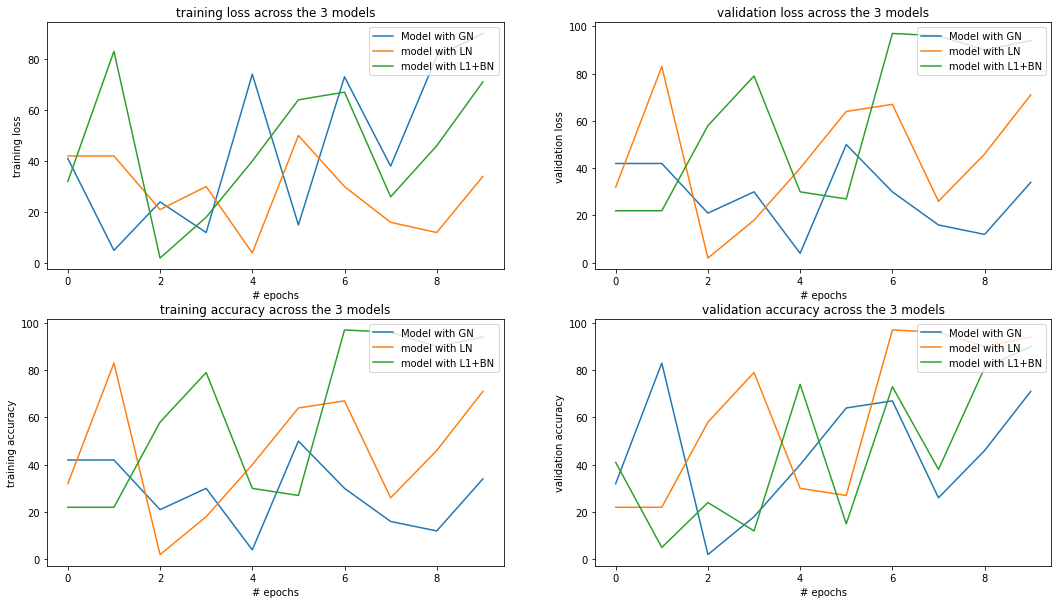

In [71]:
# Testing code for visualization function
import numpy as np
import random
s1 = np.random.randint(low=1, high=100, size=10)       
s2 = np.random.randint(low=1, high=100, size=10)  
s3 = np.random.randint(low=1, high=100, size=10)  
s4 = np.random.randint(low=1, high=100, size=10)  
s5 = np.random.randint(low=1, high=100, size=10)  
s6 = np.random.randint(low=1, high=100, size=10)  
metrics_m1 = [s1,s2,s3,s6]
metrics_m2 = [s2,s3,s4,s5]
metrics_m3 = [s3,s4,s1,s2]
fig, axs = plt.subplots(2,2, figsize = (18,10))
for i in np.arange(0,2): # represents loss/accuracy
  for j in np.arange(0,2): # represents train/validation
    axs[i,j].plot(metrics_m1[i+j])
    axs[i,j].plot(metrics_m2[i+j])
    axs[i,j].plot(metrics_m3[i+j])
    axs[i,j].set_xlabel('# epochs')
    axs[i,j].set_ylabel(f"{train_val[j]} {metric[i]}")
    axs[i,j].legend(['Model with GN', 'model with LN','model with L1+BN'], loc = 'upper right')  
    axs[i,j].set_title(f"{train_val[j]} {metric[i]} across the 3 models")



In [ ]:
def model_viz(metrics_m1, metrics_m2, metrics_m3, train_val = ["training","validation"], metric = ["loss","accuracy"]):
  """
  Visualization of 3 models and their 4 sets of metrics (train/validation X loss/accuracy)
  Each metrics_mi is a list expected in the order of [train_loss,validation_loss, train_accuracy, validation_accuracy]
  Setting up for 3 models but can be generalized for a single metrics_m1 tensor or 3-d matrix for multiple models
  """

  fig, axs = plt.subplots(2,2, figsize = (18,10))
  for i in np.arange(0,2): # represents loss/accuracy
    for j in np.arange(0,2): # represents train/validation
      axs[i,j].plot(metrics_m1[i+j])
      axs[i,j].plot(metrics_m2[i+j])
      axs[i,j].plot(metrics_m3[i+j])
      axs[i,j].set_xlabel('# epochs')
      axs[i,j].set_ylabel(f"{train_val[j]} {metric[i]}")
      axs[i,j].legend(['Model with GN', 'model with LN','model with L1+BN'], loc = 'upper right')  
      axs[i,j].set_title(f"{train_val[j]} {metric[i]} across the 3 models")

In [26]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() # to check if gpu is available
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = nnet(dropout_val = 0.05, norm_type = 'BN').to(device)
summary(model, input_size = (1,28,28))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0


In [27]:
# Model 1 summary:
model = nnet(dropout_val = 0.05, norm_type = 'BN').to(device)
summary(model, input_size = (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [36]:
# Model 2 summary:
model = nnet(dropout_val = 0.05, norm_type = 'LN').to(device)
summary(model, input_size = (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        GroupNorm-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [32]:
# Model 3 summary:
model = nnet(dropout_val = 0.05, norm_type = 'GN').to(device)
summary(model, input_size = (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        GroupNorm-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,